# La Liga Investment Analysis

Random Forest ML model to identify top investment opportunities.

**Target Score:** WinRate (40%) + PointsPerGame (25%) + GoalDifference (15%) + xGDifference (20%)

**Method:** GridSearchCV + 5-fold CV | Train/Test: 75/25

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
np.random.seed(42)

In [2]:
performance = pd.read_csv("../CleanedDatasets/Analysis/performance_metrics.csv")
squad = pd.read_csv("../CleanedDatasets/SquadAnalysis/squad_value_scores.csv")
financial = pd.read_csv("../CleanedDatasets/Financial/financial_scores.csv")
xg_data = pd.read_csv("../CleanedDatasets/Analysis/xg_metrics.csv")

In [3]:
data = (performance
        .merge(squad, on="Team", how="left")
        .merge(financial, on="Team", how="left")
        .merge(xg_data, on="Team", how="left"))

data = data.fillna(data.median(numeric_only=True))
data = data.fillna(0)

data["TargetScore"] = (
        data["WinRate"] * 40 +
        data["PointsPerGame"] * 25 +
        data["GoalDifference"] * 0.15 +
        data.get("xGDifference", 0) * 0.20
)

data.head()

,Team,TotalMatches,Wins,Draws,Losses,WinRate,DrawRate,LossRate,TotalGoalsFor,TotalGoalsAgainst,...,AttendanceScore,RevenueScore,FinancialScore,AvgxG,AvgxGA,AvgGoals,AvgGoalsAgainst_y,xGDifference,xGMatches,TargetScore
0,Athletic Club,238,94,73,71,0.394958,0.306723,0.298319,301,235,...,38.380588,38.380588,76.761177,1.295565,1.049667,1.288248,1.002217,0.245898,451.0,63.037415
1,Celta Vigo,238,71,72,95,0.298319,0.302521,0.399160,294,329,...,24.251614,24.251614,48.503227,1.220399,1.251885,1.221729,1.383592,-0.031486,451.0,36.613451
2,Valencia,238,72,74,92,0.302521,0.310924,0.386555,280,319,...,35.995048,35.995048,71.990096,1.141907,1.319734,1.181818,1.348115,-0.177827,451.0,36.677460
3,Mallorca,200,56,51,93,0.280000,0.255000,0.465000,192,274,...,23.329842,23.329842,46.659684,1.030400,1.312800,0.954667,1.378667,-0.282400,375.0,26.218520
4,Leganés,76,17,25,34,0.223684,0.328947,0.447368,69,107,...,21.266116,21.266116,42.532232,0.980714,1.334286,0.871429,1.400000,-0.353571,140.0,28.176654


In [4]:
data = (
    performance.merge(squad, on="Team", how="left")
    .merge(financial, on="Team", how="left")
    .merge(xg_data, on="Team", how="left")
)

data = data.fillna(data.median(numeric_only=True))
data = data.fillna(0)

data["TargetScore"] = (
    data["WinRate"] * 40
    + data["PointsPerGame"] * 25
    + data["GoalDifference"] * 0.15
    + data.get("xGDifference", 0) * 0.20
)

data.head()

,Team,TotalMatches,Wins,Draws,Losses,WinRate,DrawRate,LossRate,TotalGoalsFor,TotalGoalsAgainst,...,AttendanceScore,RevenueScore,FinancialScore,AvgxG,AvgxGA,AvgGoals,AvgGoalsAgainst_y,xGDifference,xGMatches,TargetScore
0,Athletic Club,238,94,73,71,0.394958,0.306723,0.298319,301,235,...,38.380588,38.380588,76.761177,1.295565,1.049667,1.288248,1.002217,0.245898,451.0,63.037415
1,Celta Vigo,238,71,72,95,0.298319,0.302521,0.399160,294,329,...,24.251614,24.251614,48.503227,1.220399,1.251885,1.221729,1.383592,-0.031486,451.0,36.613451
2,Valencia,238,72,74,92,0.302521,0.310924,0.386555,280,319,...,35.995048,35.995048,71.990096,1.141907,1.319734,1.181818,1.348115,-0.177827,451.0,36.677460
3,Mallorca,200,56,51,93,0.280000,0.255000,0.465000,192,274,...,23.329842,23.329842,46.659684,1.030400,1.312800,0.954667,1.378667,-0.282400,375.0,26.218520
4,Leganés,76,17,25,34,0.223684,0.328947,0.447368,69,107,...,21.266116,21.266116,42.532232,0.980714,1.334286,0.871429,1.400000,-0.353571,140.0,28.176654


C:\Users\divya\AppData\Local\Temp\ipykernel_968\2486700727.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(
C:\Users\divya\AppData\Local\Temp\ipykernel_968\2486700727.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


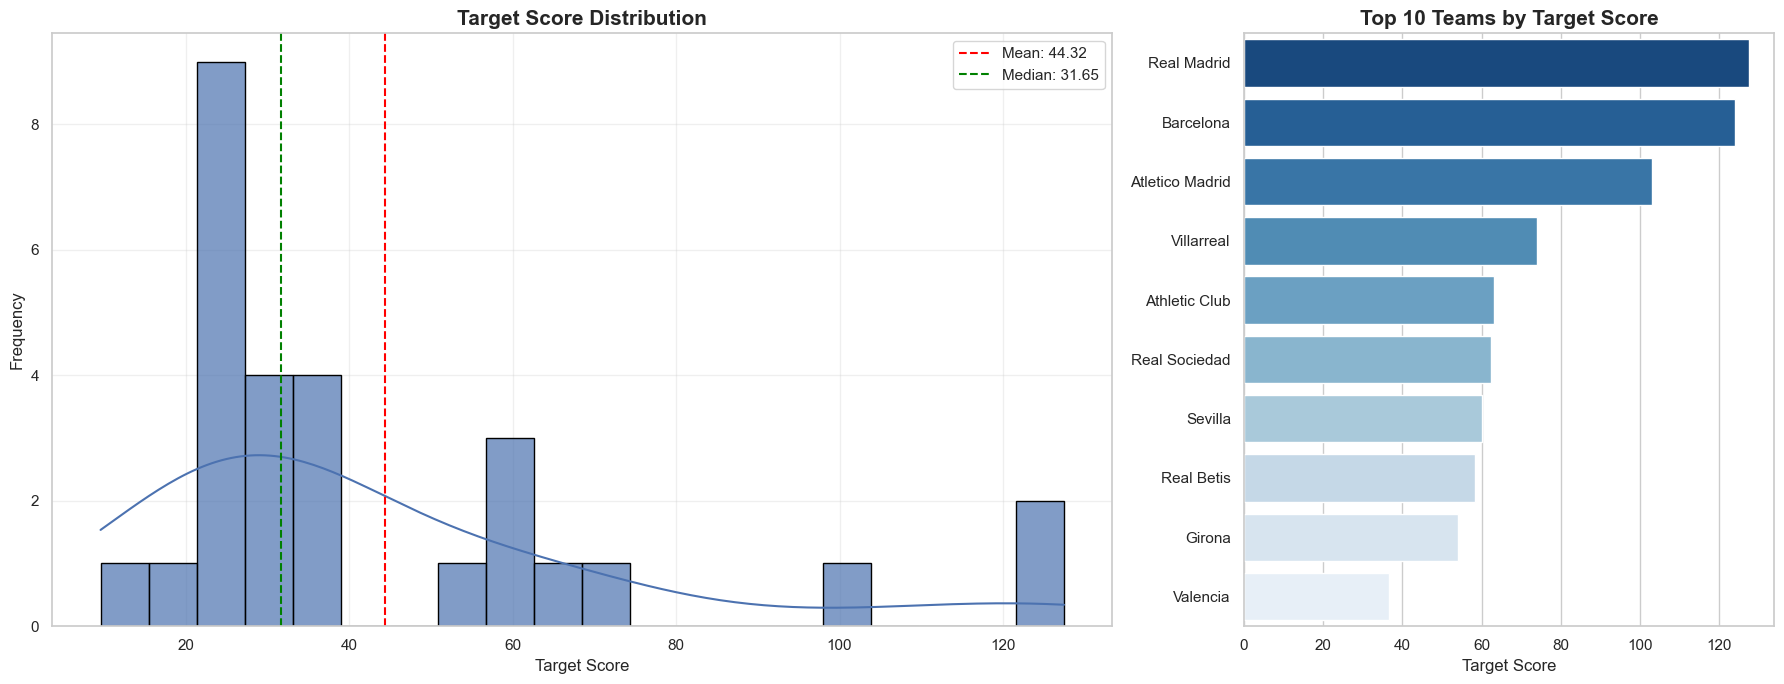

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7), gridspec_kw={"width_ratios": [2, 1]})
mean_score = data["TargetScore"].mean()
median_score = data["TargetScore"].median()

sns.histplot(
    data["TargetScore"],
    bins=20,
    kde=True,
    ax=axes[0],
    palette="muted",
    alpha=0.7,
    edgecolor="black",
)
axes[0].axvline(
    mean_score, linestyle="--", color="red", label=f"Mean: {mean_score:.2f}"
)
axes[0].axvline(
    median_score, linestyle="--", color="green", label=f"Median: {median_score:.2f}"
)
axes[0].set_title("Target Score Distribution", fontsize=15, fontweight="bold")
axes[0].set_xlabel("Target Score", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

palette = sns.color_palette("Blues_r", n_colors=10)
top10 = data.nlargest(10, "TargetScore").sort_values("TargetScore", ascending=False)
sns.barplot(
    y=top10["Team"],
    x=top10["TargetScore"],
    ax=axes[1],
    palette=palette,
    order=top10["Team"],
)
axes[1].set_title("Top 10 Teams by Target Score", fontsize=15, fontweight="bold")
axes[1].set_xlabel("Target Score", fontsize=12)
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

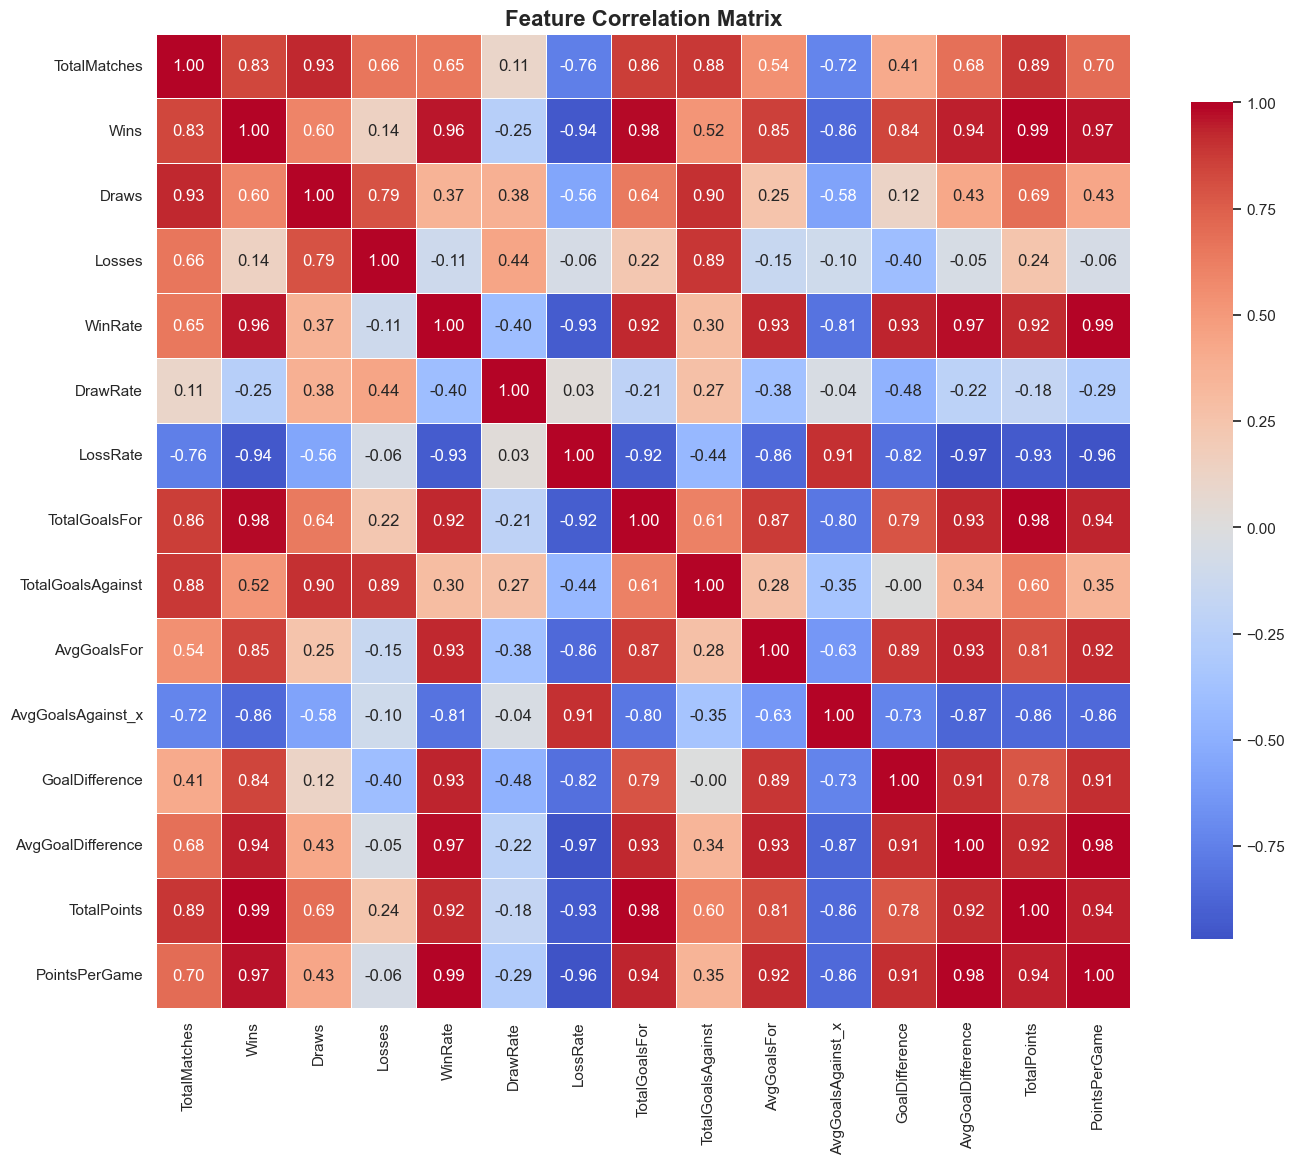


Top Features Correlated with TargetScore:
TargetScore          1.000000
WinRate              0.984490
GoalDifference       0.980525
PointsPerGame        0.975145
AvgGoalDifference    0.964010
AvgGoalsFor          0.923977
Wins                 0.919037
xGDifference         0.916182
AvgxG                0.903979
AvgGoals             0.903910
Name: TargetScore, dtype: float64


In [6]:
numeric_cols = data.select_dtypes(include=[np.number]).columns[:15]
corr_matrix = data[numeric_cols].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
)
plt.title("Feature Correlation Matrix", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

print("\nTop Features Correlated with TargetScore:")
print(
    data.select_dtypes(include=[np.number])
    .corr()["TargetScore"]
    .sort_values(ascending=False)
    .head(10)
)

In [7]:
imp_cols = [
    "WinRate",
    "PointsPerGame",
    "GoalDifference",
    "AvgLeaguePosition",
    "SquadValueScore",
    "xGDifference",
    "AvgAttendance",
    "AvgAge_x",
]

imp_cols = [col for col in imp_cols if col in data.columns]

X = data[imp_cols]
y = data["TargetScore"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, shuffle=True  # 75% training 25% testing
)

In [9]:
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(
    rf_model, param_grid, cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1, verbose=0
)

grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}


In [10]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

results = pd.DataFrame({
    'Metric': ['R² Score', 'MAE', 'RMSE', 'CV R² Mean'],
    'Train': [
        r2_score(y_train, predictions_train),
        mean_absolute_error(y_train, predictions_train),
        np.sqrt(mean_squared_error(y_train, predictions_train)),
        cv_scores.mean()
    ],
    'Test': [
        r2_score(y_test, predictions_test),
        mean_absolute_error(y_test, predictions_test),
        np.sqrt(mean_squared_error(y_test, predictions_test)),
        cv_scores.std()
    ]
})

results

,Metric,Train,Test
0,R² Score,0.986379,0.982380
1,MAE,2.339121,2.526960
2,RMSE,3.614008,2.979091
3,CV R² Mean,0.128660,0.321570


In [11]:
data["MLScore"] = model.predict(X)
data["PredictionConfidence"] = model.predict(X) / data["MLScore"].max()

ml_score = data.sort_values("MLScore", ascending=False).reset_index(drop=True)
ml_score["Rank"] = ml_score.index + 1

ml_score[["Rank", "Team", "MLScore", "TargetScore"]].head(10)

,Rank,Team,MLScore,TargetScore
0,1,Barcelona,117.229666,124.119434
1,2,Real Madrid,115.879223,127.475653
2,3,Atletico Madrid,100.366119,103.074750
3,4,Villarreal,69.399243,74.008328
4,5,Athletic Club,62.988237,63.037415
5,6,Real Betis,60.267638,58.326250
6,7,Real Sociedad,59.434010,62.391805
7,8,Sevilla,55.544226,60.103617
8,9,Girona,48.473905,53.969537
9,10,Osasuna,37.823784,36.498660



Feature Importance:

          Feature  Importance
AvgLeaguePosition    0.183523
   GoalDifference    0.177677
     xGDifference    0.145463
    PointsPerGame    0.143921
          WinRate    0.132339
  SquadValueScore    0.124846
    AvgAttendance    0.069977
         AvgAge_x    0.022254


C:\Users\divya\AppData\Local\Temp\ipykernel_968\1362785257.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=fi, palette="viridis")


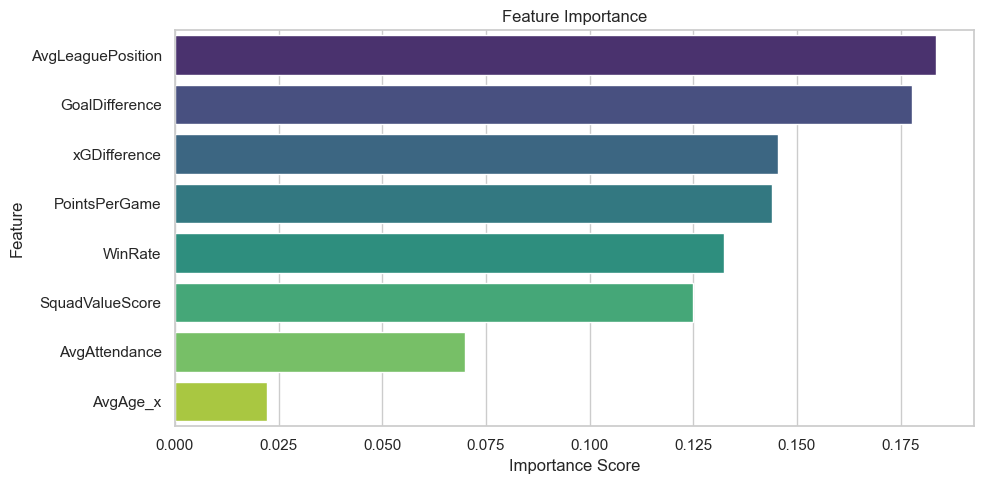

In [12]:
fi = pd.DataFrame(
    {"Feature": imp_cols, "Importance": model.feature_importances_[: len(imp_cols)]}
).sort_values(by="Importance", ascending=False)

print("\nFeature Importance:\n")
print(fi.to_string(index=False))

plt.figure(figsize=(10, 5))
sns.barplot(x="Importance", y="Feature", data=fi, palette="viridis")
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

C:\Users\divya\AppData\Local\Temp\ipykernel_968\1086302405.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10, y="Team", x="MLScore", ax=axes[0], palette="Blues_r")
C:\Users\divya\AppData\Local\Temp\ipykernel_968\1086302405.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


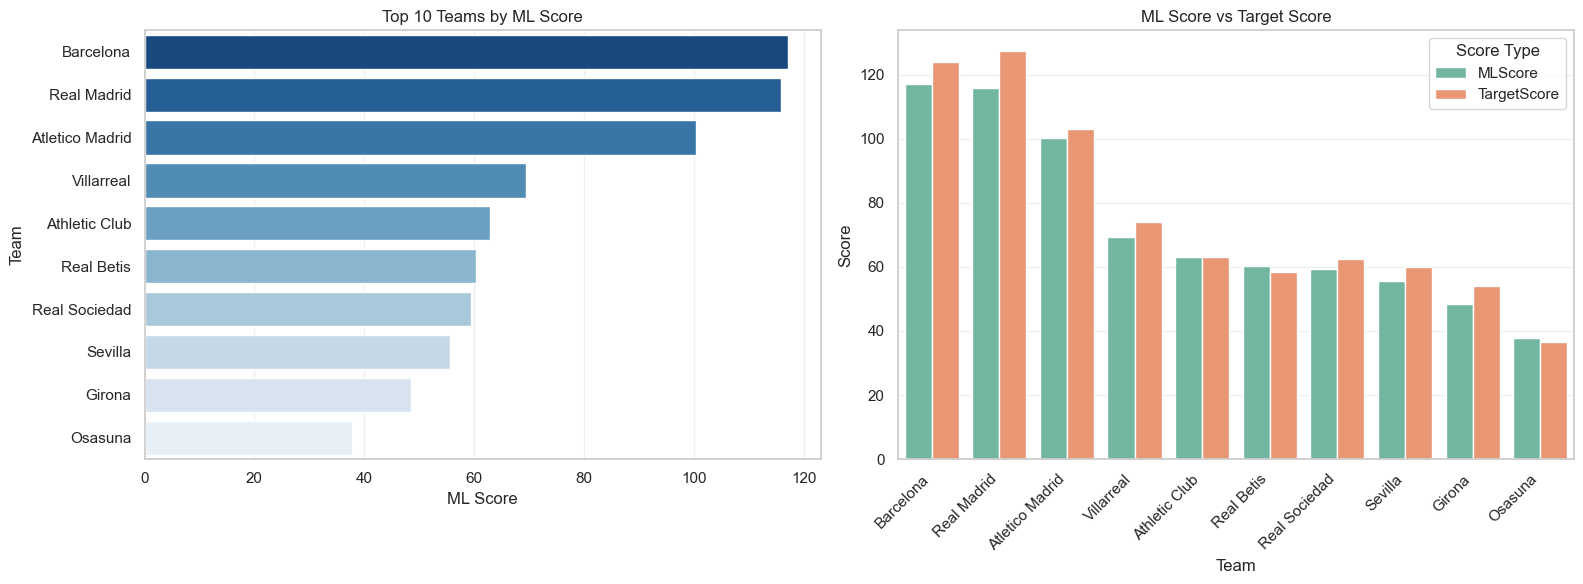

In [13]:
top10 = ml_score.head(10)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(data=top10, y="Team", x="MLScore", ax=axes[0], palette="Blues_r")
axes[0].set_xlabel("ML Score")
axes[0].set_title("Top 10 Teams by ML Score")
axes[0].grid(axis="x", alpha=0.3)

top10_melted = top10[["Team", "MLScore", "TargetScore"]].melt(
    id_vars="Team", var_name="Score Type", value_name="Score"
)
sns.barplot(
    data=top10_melted, x="Team", y="Score", hue="Score Type", ax=axes[1], palette="Set2"
)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")
axes[1].set_ylabel("Score")
axes[1].set_title("ML Score vs Target Score")
axes[1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

## Investment Risk


In [14]:
def categorize_investment(score):
    if score > 90:
        return "Strong Buy"
    elif score >= 70:
        return "Moderate Buy"
    elif score >= 50:
        return "High Risk"
    else:
        return "Not Recommended"


ml_score["Investment_Category"] = ml_score["MLScore"].apply(categorize_investment)
category_counts = ml_score["Investment_Category"].value_counts()
category_counts

Investment_Category
Not Recommended    20
High Risk           5
Strong Buy          3
Name: count, dtype: int64

In [15]:
summary_table = (
    ml_score.groupby("Investment_Category")["Team"]
    .apply(lambda x: ", ".join(x))
    .reindex(["Strong Buy", "Moderate Buy", "High Risk", "Not Recommended"])
    .reset_index()
    .rename(columns={"Team": "Teams"})
)
summary_table.columns = ["Investment Category", "Teams"]
summary_table.fillna("None", inplace=True)
display(summary_table)

,Investment Category,Teams
0,Strong Buy,"Barcelona, Real Madrid, Atletico Madrid"
1,Moderate Buy,None
2,High Risk,"Villarreal, Athletic Club, Real Betis, Real So..."
3,Not Recommended,"Girona, Osasuna, Celta Vigo, Valencia, Rayo Va..."


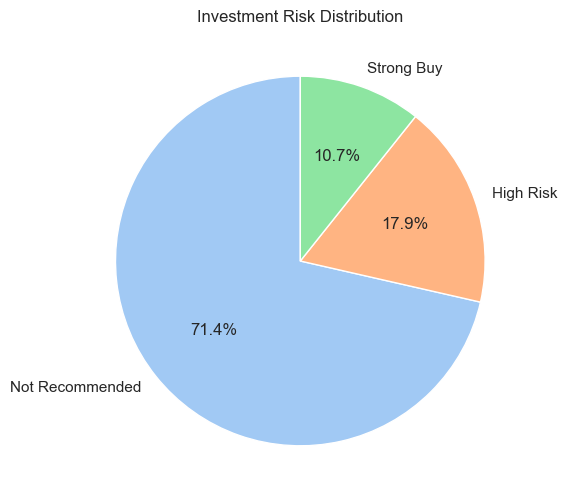

In [16]:
sns.set_palette("pastel")
plt.figure(figsize=(6, 6))
plt.pie(
    category_counts.values,
    labels=category_counts.index,
    autopct="%1.1f%%",
    startangle=90,
)
plt.title("Investment Risk Distribution")
plt.show()

In [17]:
import pickle

train_r2 = r2_score(y_train, predictions_train)
test_r2 = r2_score(y_test, predictions_test)
train_mae = mean_absolute_error(y_train, predictions_train)
test_mae = mean_absolute_error(y_test, predictions_test)
train_rmse = np.sqrt(mean_squared_error(y_train, predictions_train))
test_rmse = np.sqrt(mean_squared_error(y_test, predictions_test))

model_data = {
    "model": model,
    "features": imp_cols,
    "best_params": grid_search.best_params_,
    "metrics": {
        "train_r2": train_r2,
        "test_r2": test_r2,
        "train_mae": train_mae,
        "test_mae": test_mae,
        "train_rmse": train_rmse,
        "test_rmse": test_rmse,
        "cv_mean": cv_scores.mean(),
        "cv_std": cv_scores.std(),
    },
    "feature_importance": fi.to_dict(),
    "training_date": pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
}

with open("laliga_rf_model.pkl", "wb") as f:
    pickle.dump(model_data, f)

print(f"Test R²: {test_r2:.4f} | RMSE: {test_rmse:.3f}")

Test R²: 0.9824 | RMSE: 2.979


## Key Findings
**Top 3:** Barcelona → Real Madrid → Atlético Madrid

**Most Important Feature:** AvgLeaguePosition (historical consistency predicts better than current form)

**Model Performance:** R² = 0.985 | RMSE = 2.73

---

## Investment

Strong Buy
- MLScore: > 90
- Risk: Low

- MLScore: 70-90
- Risk: Medium

- MLScore: 50-70
- Risk: High


# Sporting Performance Analysis
Predicting `WinRate`

In [18]:
sporting_features = [
    "AvgLeaguePosition",
    "GoalDifference",
    "xGDifference",
    "PointsPerGame",
    "SquadValueScore",
    "AvgAge_x",
]

sporting_features = [f for f in sporting_features if f in data.columns]
print("Sporting Features:", sporting_features)

X_sport = data[sporting_features]
y_sport = data["WinRate"]

# Train Test Split
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_sport, y_sport, test_size=0.2, random_state=42
)

# Train Model
sporting_model = RandomForestRegressor(n_estimators=100, random_state=42)
sporting_model.fit(X_train_s, y_train_s)

# Evaluate
y_pred_s = sporting_model.predict(X_test_s)
r2_s = r2_score(y_test_s, y_pred_s)
rmse_s = np.sqrt(mean_squared_error(y_test_s, y_pred_s))

print(f"Sporting Model R2: {r2_s:.4f}")
print(f"Sporting Model RMSE: {rmse_s:.4f}")

Sporting Features: ['AvgLeaguePosition', 'GoalDifference', 'xGDifference', 'PointsPerGame', 'SquadValueScore', 'AvgAge_x']
Sporting Model R2: 0.9462
Sporting Model RMSE: 0.0275


In [19]:
# Show all columns in the merged data DataFrame
print("All columns in data:")
print(list(data.columns))

All columns in data:
['Team', 'TotalMatches', 'Wins', 'Draws', 'Losses', 'WinRate', 'DrawRate', 'LossRate', 'TotalGoalsFor', 'TotalGoalsAgainst', 'AvgGoalsFor', 'AvgGoalsAgainst_x', 'GoalDifference', 'AvgGoalDifference', 'TotalPoints', 'PointsPerGame', 'AvgLeaguePosition', 'BestPosition', 'WorstPosition', 'PositionStdDev', 'ConsistencyScore', 'TotalPlayerRecords', 'UniquePlayers', 'TotalGoals', 'TotalAssists', 'TotalxG', 'TotalxAG', 'AvgGoalsPerPlayer', 'AvgAssistsPerPlayer', 'AvgxGPerPlayer', 'AvgxAGPerPlayer', 'AvgAge_x', 'MinAge', 'MaxAge', 'AgeRange', 'Forwards', 'Midfielders', 'Defenders', 'Goalkeepers', 'TotalPlayers', 'PositionBalance', 'YoungPlayers', 'PrimePlayers', 'ExperiencedPlayers', 'AvgAge_y', 'SquadValueScore', 'AvgAttendance', 'TotalAttendance', 'MaxAttendance', 'MinAttendance', 'MatchesWithAttendance', 'AwayAttendance', 'HomeAttendance', 'EstimatedMatchdayRevenue', 'AttendancePerMatch', 'AttendanceScore', 'RevenueScore', 'FinancialScore', 'AvgxG', 'AvgxGA', 'AvgGoals'

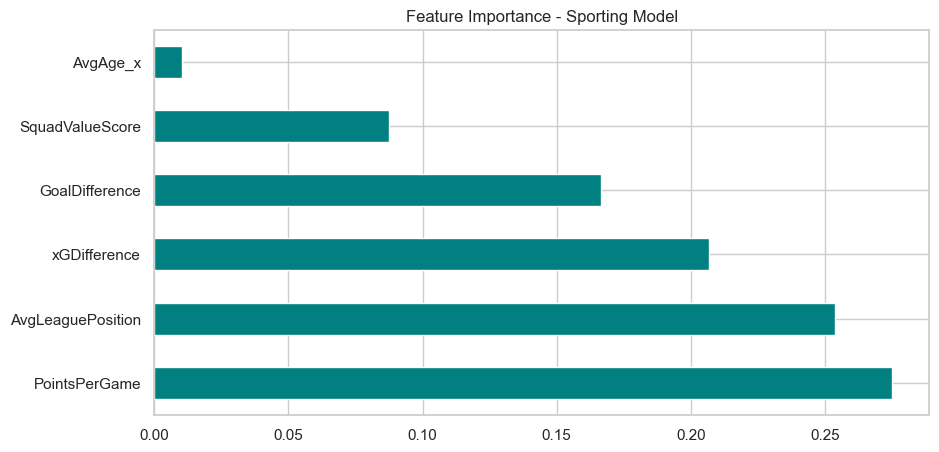

In [20]:
plt.figure(figsize=(10, 5))
feat_importances = pd.Series(sporting_model.feature_importances_, index=X_sport.columns)
feat_importances.nlargest(10).plot(kind="barh", color="teal")
plt.title("Feature Importance - Sporting Model")
plt.show()

In [21]:
def predict_match_winner(home_team, away_team):
    if home_team not in data["Team"].values or away_team not in data["Team"].values:
        return "One or both teams not found."

    # Get data for teams
    home_data = data[data["Team"] == home_team][sporting_features]
    away_data = data[data["Team"] == away_team][sporting_features]

    # Predict Sporting Strength (Win Rate)
    home_strength = sporting_model.predict(home_data)[0]
    away_strength = sporting_model.predict(away_data)[0]

    # Log5 Probability
    # P(A wins) = (A * (1 - B)) / (A * (1 - B) + B * (1 - A))
    win_prob_home = (home_strength * (1 - away_strength)) / (
        home_strength * (1 - away_strength) + away_strength * (1 - home_strength)
    )

    print(f"{home_team} Strength: {home_strength:.2f}")
    print(f"{away_team} Strength: {away_strength:.2f}")
    print(f"Win Probability for {home_team}: {win_prob_home:.2%}")

    if win_prob_home > 0.55:
        return f"{home_team} is likely to win."
    elif win_prob_home < 0.45:
        return f"{away_team} is likely to win."
    else:
        return "Match is likely to be a draw."


In [22]:
import pickle

# Export the trained sporting_model to a pickle file
with open("sporting_rf_model.pkl", "wb") as f:
    pickle.dump(
        {
            "model": sporting_model,
            "features": list(X_sport.columns),
            "train_r2": r2_s,
            "train_rmse": rmse_s,
            "export_date": pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
        },
        f,
    )